In [1]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv("heart.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [11]:
# first we check if there are some missing values in the columns where there shouldn't be any
print(df['age'].value_counts().isnull().sum())
print(df['trestbps'].value_counts().isnull().sum())
print(df['chol'].value_counts().isnull().sum())
print(df['thalach'].value_counts().isnull().sum())
print(df['oldpeak'].value_counts().isnull().sum())

0
0
0
0
0


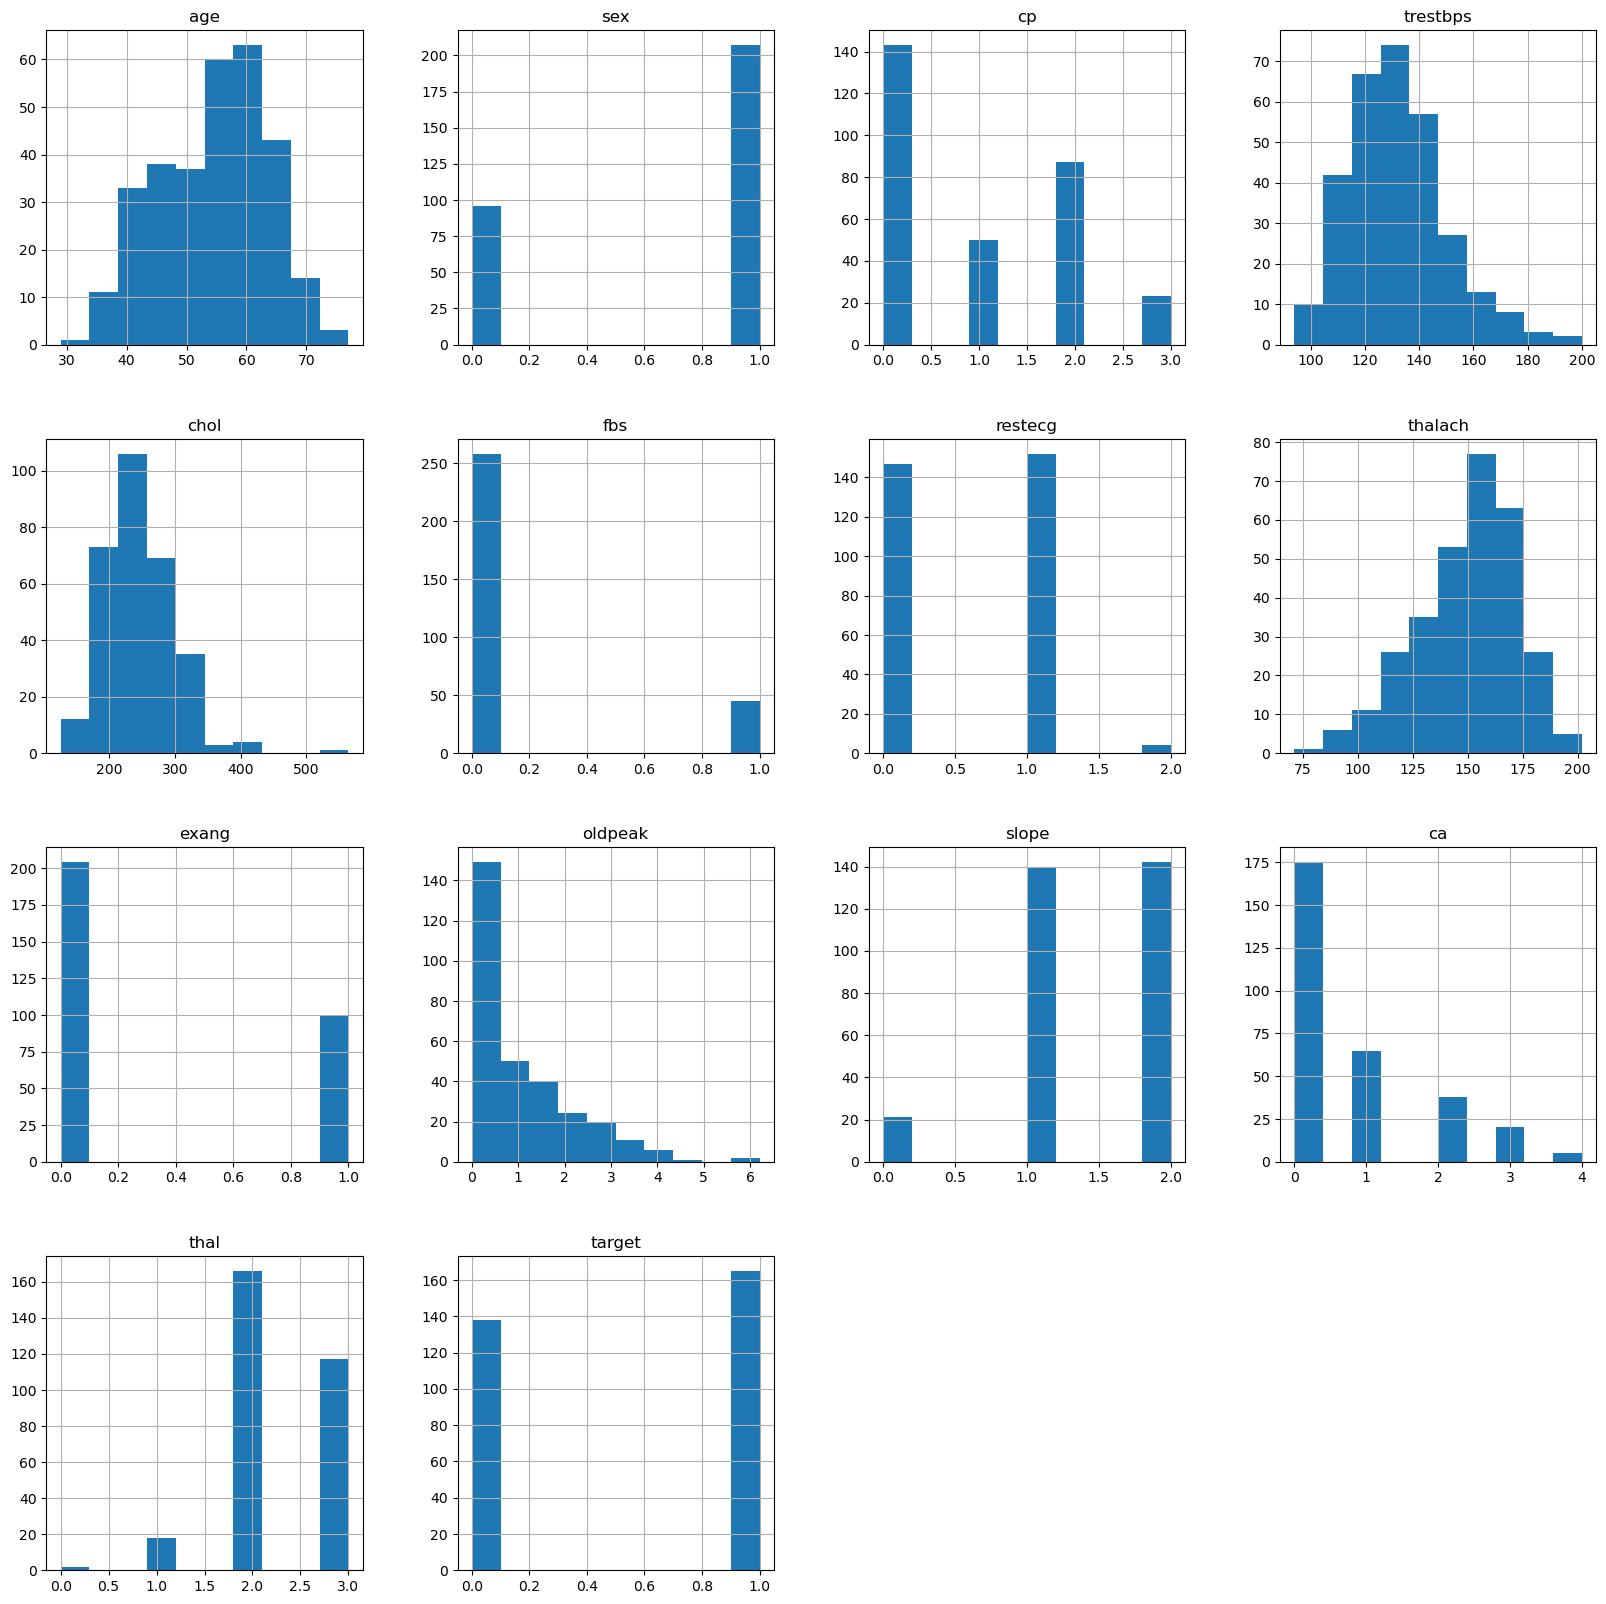

In [13]:
p = df.hist(figsize = (20,20))

<AxesSubplot:>

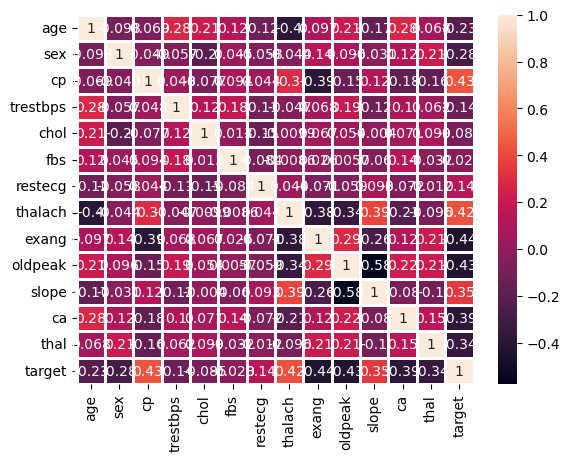

In [16]:
import seaborn as sns
sns.heatmap(df.corr(), annot = True, linewidth = 1)

In [28]:
X = df.drop(['target'], axis=1) # we create a dataframe with independent variable
y = df['target'] # a dataframe (column-vector) with dependent (output) variable 

In [18]:
from sklearn.feature_selection import SelectKBest, chi2 
best_features = SelectKBest(chi2, k = 8) # We select chi2 as a score function; k = 8 means that we opt to select 8 best features
model = best_features.fit(X,y)
dfscores = pd.DataFrame(model.scores_)
dfcolumns = pd.DataFrame(X.columns)

In [19]:
featureScores = pd.concat([dfcolumns,dfscores], axis = 1)
featureScores.columns = ['Features', 'Score']
print(featureScores.nlargest(13,'Score'))

    Features       Score
7    thalach  188.320472
9    oldpeak   72.644253
11        ca   66.440765
2         cp   62.598098
8      exang   38.914377
4       chol   23.936394
0        age   23.286624
3   trestbps   14.823925
10     slope    9.804095
1        sex    7.576835
12      thal    5.791853
6    restecg    2.978271
5        fbs    0.202934


In [20]:
X = X.drop(['fbs', 'restecg','thal', 'sex', 'slope'], axis = 1) # We drop everything but first 8 features

,age,cp,trestbps,chol,thalach,exang,oldpeak,ca
0,63,3,145,233,150,0,2.3,0
1,37,2,130,250,187,0,3.5,0
2,41,1,130,204,172,0,1.4,0
3,56,1,120,236,178,0,0.8,0
4,57,0,120,354,163,1,0.6,0


In [22]:
from sklearn.preprocessing import StandardScaler
df_best_features = X.copy(deep = True) # creating a dataframe with 8 best features
df_best_features['target'] = pd.DataFrame(y) # adding output variable to the dataframe

scaler = StandardScaler()
# Creating a standardized dataframe; first we need to drop the output variable because we don't need to standardize it
df_standardized = pd.DataFrame(scaler.fit_transform(df_best_features.drop(['target'], axis = 1)), columns = df_best_features.columns.drop(['target']))
# Once again we add the output variable to the standardized dataframe
df_standardized['target'] = df_best_features['target']
df_standardized.head()

,age,cp,trestbps,chol,thalach,exang,oldpeak,ca,target
0,0.952197,1.973123,0.763956,-0.256334,0.015443,-0.696631,1.087338,-0.714429,1
1,-1.915313,1.002577,-0.092738,0.072199,1.633471,-0.696631,2.122573,-0.714429,1
2,-1.474158,0.032031,-0.092738,-0.816773,0.977514,-0.696631,0.310912,-0.714429,1
3,0.180175,0.032031,-0.663867,-0.198357,1.239897,-0.696631,-0.206705,-0.714429,1
4,0.290464,-0.938515,-0.663867,2.082050,0.583939,1.435481,-0.379244,-0.714429,1


<AxesSubplot:>

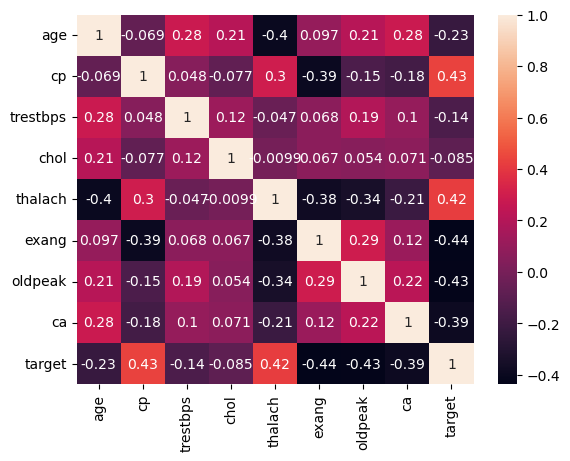

In [23]:
import seaborn as sns
sns.heatmap(df_standardized.corr(), annot = True)

We see in the correlation map that there is not any strong correlation between the variables, so we don't need to drop any more features

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

X_st = df_standardized.drop(['target'], axis = 1) # creating standardized dataframe of independent variables, axis is 1 because we drop column
clf = DecisionTreeClassifier(random_state = 1) # creating a classifier
k_folds = StratifiedKFold(shuffle = True, n_splits = 5, random_state = 10)
scores = cross_val_score(clf, X_st, y, cv = k_folds)
print("Cross Validation Scores: ", scores)
print("Average CV Score: ", scores.mean())
print("Number of CV Scores used in Average: ", len(scores))

Cross Validation Scores:  [0.75409836 0.63934426 0.68852459 0.7        0.8       ]
Average CV Score:  0.7163934426229508
Number of CV Scores used in Average:  5


By checking the Cross Validation Scores we see that the model can generalize over the whole dataset because the scores of each fold are pretty close 

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_st, y, random_state = 42, test_size = 1/3, stratify = y)
# size of the test dataset will be 1/3 the size of whole dataset, while remaining data (2/3) will be used for training
# the 'stratify' parameter means that data in test and train subsets will be split in a ratio that is equal to how it was in an origin dataset
# we mean equal in term of a number of each class
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state = 0, max_depth = 4)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
print('The accuracy score is ', accuracy_score(y_test, y_pred))
print('The precision score is ', precision_score(y_test, y_pred))
print('The recall score is ', recall_score(y_test, y_pred))

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

The accuracy score is  0.8217821782178217
The precision score is  0.8032786885245902
The recall score is  0.8909090909090909
[[34 12]
 [ 6 49]]


The accuracy we achieved with max_depth = 4 is 82.17%. Now we will use GridSearchCV to check if we can improve the model with
other parameteres

In [48]:
from sklearn.model_selection import GridSearchCV
tree_params = {'criterion':['gini','entropy', 'log_loss'],'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
clf = GridSearchCV(DecisionTreeClassifier(), tree_params, cv=5)
clf.fit(X_train, y_train)
print(clf.best_params_)
print(clf.best_estimator_)
print(clf.best_score_)

{'criterion': 'gini', 'max_depth': 3}
DecisionTreeClassifier(max_depth=3)
0.7874390243902438


With the use of GridSearchCV we found out that the best possible parameters for this model are criterion = 'gini' and 'max_depth' = 3. 